# Домашнее задание 2. Классификация, детекция.

Драмбян Давид

Оценка за часть 1 и часть 2 в этом дз -- по 5 баллов.

## Часть 1. Классификация

В этом задании потребуется обучить классификатор изображений. Будем работать с датасетом, название которого раскрывать не будем. Можете посмотреть самостоятельно на картинки, которые в датасете есть. В нём 200 классов и около 5 тысяч картинок на каждый класс. Классы пронумерованы, как нетрудно догадаться, от 0 до 199. Скачать датасет можно вот [тут](https://yadi.sk/d/BNR41Vu3y0c7qA).

Структура датасета простая -- есть директории train и val, в которых лежат обучающие и валидационные данные. В train/ и val/ лежат директориии, соответствующие классам изображений, в которых лежат собственно сами изображения.
 
__Задание__. Добейтесь accuracy **не менее 0.44**. Напишите краткий отчёт о проделанных экспериментах. Что сработало и что не сработало? Почему вы решили, сделать так, а не иначе? Обязательно указывайте ссылки на чужой код, если вы его используете. Обязательно ссылайтесь на статьи/блогпосты/вопросы на stackoverflow/видосы от (индийских) ютуберов/курсы/подсказки от Дяди Васи и прочие дополнительные материалы, если вы их используете. 

В коде ниже необходимо, чтобы код проходил все `assert`'ы.

Необходимо написать функцию `predict` по шаблону ниже. Эта функция принимает на вход модель, даталоадер с валидационнами данными, criterion для подсчёта лосса и device, на котором будут производиться вычисления (определён ниже) и возвращает список лоссов по всем объектам, список из предсказанных классов для каждого объекта из из даталоалера и список из настоящих классов для каждого объекта в даталоадере (и именно в таком порядке).

__Использовать внешние данные для обучения строго запрещено__. Можно использовать предобученные модели из `torchvision`.

__Критерии оценки__: Оценка вычисляется по простой формуле: min(5, 5 * Ваша accuracy / 0.44). Оценка округляется до десятых по арифметическим правилам.

__Советы и указания__:
 - Наверняка вам потребуется много гуглить о классификации и о том, как заставить её работать. Это нормально, все гуглят. Но не забывайте, что нужно быть готовым за скатанный код отвечать на защите :)
 - Используйте аугментации. Для этого пользуйтесь модулем torchvision.transforms или библиотекой [albumentations](https://github.com/albumentations-team/albumentations)
 - (ещё раз) Можно файнтюнить предобученные модели из `torchvision`.
 - Рекомендуем написать вам сначала класс-датасет (или воспользоваться классом ImageFolder), который возвращает картинки и соответствующие им классы, а затем функции для трейна по шаблонам ниже. Однако делать это мы не заставляем. Если вам так неудобно, то можете писать код в удобном стиле. Однако учтите, что чрезмерное изменение нижеперечисленных шаблонов увеличит количество вопросов к вашему коду и повысит вероятность вызова на защиту :)
 - Валидируйте. Трекайте ошибки как можно раньше, чтобы не тратить время впустую.
 - Чтобы отладить код, пробуйте обучаться на маленькой части датасета. Когда вы поняли, что смогли всё отдебажить, переходите обучению по всему датасету
 - На каждый запуск делайте ровно одно изменение в модели/аугментации/оптимайзере, чтобы понять, что и как влияет на результат.
 - Фиксируйте random seed.
 - Начинайте с простых моделей и постепенно переходите к сложным. Обучение лёгких моделей экономит много времени.
 - Ставьте расписание на learning rate. Уменьшайте его, когда лосс на валидации перестаёт убывать.
 - Советуем использовать гпу. Если у вас его нет, используйте google colab. Если вам неудобно его использовать на постоянной основе, напишите и отладьте весь код локально на CPU, а затем запустите уже написанный ноутбук в колабе. Авторское решение задания достигает требуемой точности в колабе за 15 минут обучения.
 
Good luck & have fun! :)

In [1]:
import torch
import numpy as np
import random

import os
from os.path import isfile, join
import time
import PIL
from PIL import Image
from sklearn.metrics import auc

import torch
import torchvision
from torch import nn
from torch.nn import functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

In [2]:
# Скачивал датасет с drive.google
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
! unzip -q -o '/content/drive/My Drive/dataset.zip'

In [4]:
# Буду превентивно фиксировать seed во всех ячейках, где что-то происходит. 
# В этом мне поможет эта четверка

np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
random.seed(42)

# Колхоз? Да. 
# Можно было не пихать его во все ячейки, а только в те, где есть стохастичность? Да.
# Стыдно ли мне за это? Нет.

In [5]:
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
random.seed(42)

# sem_06 KINDA WORKS
# open dataset and get access to its elements
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, transform=None):
        self.root = data_dir
        self.transform = transform
        
        self.classes = sorted(list(os.listdir(data_dir)))

        self.photos_idxs = sorted(list(os.listdir(os.path.join(data_dir, self.classes[0]))))
        self.total_photos = []
        self.ind = []
        
    def __getitem__(self, idx):
        cl = self.classes[idx // len(self.photos_idxs)]
        it = self.photos_idxs[idx % len(self.photos_idxs)]
        pic_path = os.path.join(self.root, cl, it)

        img = Image.open(pic_path).convert("RGB")
        target = int(cl.strip('class__'))

        if self.transform is not None:
            img = self.transform(img)

        return (img, target)

    def __len__(self):
        return len(self.classes) * len(self.photos_idxs)

In [6]:
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
random.seed(42)

# sem03
# аугментация и для обучающей, и для валидационной
transforms_trch = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224,224)),
    torchvision.transforms.ColorJitter(hue=.05, saturation=.05),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
])

In [7]:
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
random.seed(42)

train_transform = transforms_trch
val_transform = transforms_trch

train_dataset = MyDataset("/content/dataset/dataset/train", transform=train_transform)
val_dataset = MyDataset("/content/dataset/dataset/val", transform=val_transform)
# REPLACE ./dataset/dataset WITH THE FOLDER WHERE YOU DOWNLOADED AND UNZIPPED THE DATASET
# OR USE torchvision.datasets.ImageFolder INSTEAD OF MyDataset

In [8]:
# sem_06
def imgshow(objct):
    to_PIL = torchvision.transforms.ToPILImage()

    img = objct
    img = np.array(to_PIL(img))

    plt.imshow(img)

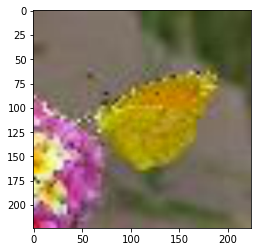

In [9]:
imgshow(train_dataset[0][0])

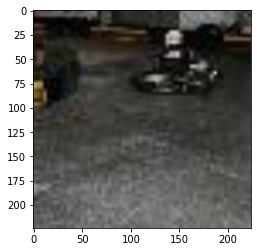

In [10]:
imgshow(train_dataset[43*500+2][0])

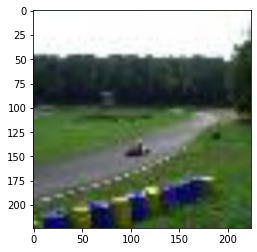

In [11]:
imgshow(train_dataset[43*500+3][0])

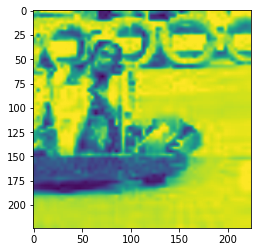

In [12]:
# только один слой

# plt.imshow(train_dataset.__getitem__(43*500+1)[0][0])
imgshow(train_dataset[43*500+1][0][0])

In [13]:
train_dataset.__getitem__(0)

(tensor([[[0.2745, 0.2745, 0.2784,  ..., 0.4667, 0.4667, 0.4667],
          [0.2745, 0.2745, 0.2784,  ..., 0.4667, 0.4667, 0.4667],
          [0.2745, 0.2745, 0.2784,  ..., 0.4667, 0.4667, 0.4667],
          ...,
          [0.5373, 0.5373, 0.5373,  ..., 0.7490, 0.7686, 0.7686],
          [0.5412, 0.5412, 0.5373,  ..., 0.7765, 0.8039, 0.8039],
          [0.5412, 0.5412, 0.5373,  ..., 0.7765, 0.8039, 0.8039]],
 
         [[0.2863, 0.2863, 0.2902,  ..., 0.4000, 0.4000, 0.4000],
          [0.2863, 0.2863, 0.2902,  ..., 0.4000, 0.4000, 0.4000],
          [0.2863, 0.2863, 0.2902,  ..., 0.4000, 0.4000, 0.4000],
          ...,
          [0.4824, 0.4824, 0.4824,  ..., 0.1294, 0.1373, 0.1373],
          [0.4863, 0.4863, 0.4824,  ..., 0.1529, 0.1686, 0.1686],
          [0.4863, 0.4863, 0.4824,  ..., 0.1529, 0.1686, 0.1686]],
 
         [[0.1373, 0.1373, 0.1412,  ..., 0.3686, 0.3686, 0.3686],
          [0.1373, 0.1373, 0.1412,  ..., 0.3686, 0.3686, 0.3686],
          [0.1373, 0.1373, 0.1412,  ...,

Все нормально. Изображения аугментируются. 

In [14]:
# Just very simple checks
assert isinstance(train_dataset[0], tuple)
assert len(train_dataset[0]) == 2
assert isinstance(train_dataset[1][1], int)
print("tests passed")

tests passed


In [15]:
import tqdm
from sklearn.metrics import accuracy_score
import sys

In [16]:
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
random.seed(42)

# sem05 x2
# a function to train one epoch 
def train_one_epoch(model, train_dataloader, criterion, optimizer, return_losses=False, device="cuda:0"):
    model = model.to(device).train()
    total_loss = 0
    num_batches = 0
    all_losses = []
    total_predictions = np.array([])#.reshape((0, ))
    total_labels = np.array([])#.reshape((0, ))
    # with tqdm(total=500*200, file=sys.stdout) as prbar:
    for images, labels in train_dataloader:
        # Move Batch to GPU
        # images = images.unsqueeze(dim=0)
        # labels = torch.zeros(1, dtype=torch.long) + labels
        # labels = torch.tensor([labels], dtype=torch.long)
        images = images.to(device)
        labels = labels.to(device)

        predicted = model(images)
        loss = criterion(predicted, labels)
        # Update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Update accuracy and total
        accuracy = (predicted.argmax(1) == labels).sum()/len(labels)

        total_loss += loss.item()
        total_predictions = np.append(total_predictions, predicted.argmax(1).cpu().detach().numpy())
        total_labels = np.append(total_labels, labels.cpu().detach().numpy())

        if num_batches % 100 == 0:
            print(num_batches, end = ' ')

            print('loss: ' + str(loss.item()), end = ' ')
            print('accuracy: ' + str(accuracy.item()))
        
        num_batches += 1
        
        all_losses.append(loss.detach().item())
    
    metrics = {'loss': total_loss / num_batches}
    metrics.update({"accuracy": (total_predictions == total_labels).mean()})
    if return_losses:
        return metrics, all_losses
    else:
        return metrics
    pass

# prediction function 
def predict(model, val_dataloder, criterion, device="cuda:0"):
    # model = model.eval()
    model = model.to(device).eval()
    total_loss = 0
    num_batches = 0
    total_predictions = np.array([])
    total_labels = np.array([])
    for images, labels in val_dataloder:
        images = images.to(device)
        labels = labels.to(device)

        predicted = model(images)
        loss = criterion(predicted, labels)
        accuracy = (predicted.argmax(1) == labels).sum()/len(labels)    
        
        total_loss += loss.item()
        total_predictions = np.append(total_predictions, predicted.argmax(1).cpu().detach().numpy())
        total_labels = np.append(total_labels, labels.cpu().detach().numpy())

        num_batches += 1

        
    avg_val_loss = total_loss / num_batches

    
    return avg_val_loss, total_predictions, total_labels


# Train. Evaluate. Repeat. 
def train(model, train_data_loader, validation_data_loader, criterion, optimizer, device="cuda:0", n_epochs=10, scheduler=None):
    model.to(device)
    all_train_losses = []
    epoch_train_losses = []
    epoch_eval_losses = []
    for epoch in range(n_epochs):
        # Train step
        print(f"Train Epoch: {epoch}")
        train_metrics, one_epoch_train_losses = train_one_epoch(
            model=model,
            train_dataloader=train_data_loader,
            optimizer=optimizer,
            return_losses=True,
            criterion=criterion
        )
        train_losses = train_metrics['loss']
        # Save Train losses
        all_train_losses += one_epoch_train_losses # .extend(one_epoch_train_losses)
        epoch_train_losses.append(train_losses)
        print('!!! TRAIN EPOCH METRICS: !!!')
        print(train_metrics)
        # Eval step
        print(f"Validation Epoch: {epoch}")
        with torch.no_grad():
            avg_val_loss, total_predictions, total_labels = predict(
                model=model,
                val_dataloder=validation_data_loader,
                criterion=criterion
            )
        val_epoch_acc = (total_predictions == total_labels).mean()
        print('!!! VAL EPOCH METRICS: !!!')
        print('loss: ' + str(avg_val_loss) + ', accuracy: ' + str(val_epoch_acc))
        # Save eval losses
        epoch_eval_losses.append(avg_val_loss)

In [17]:
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
random.seed(42)

# использую resnet18 в качестве базовой модели
from torchvision.models import resnet18

model_v2 = resnet18(pretrained=True)
# param.requires_grad = False - для того, чтобы не переобучатьь весь resnet
for param in model_v2.parameters():
    param.requires_grad = False

# поменяю полносвязный слой на (512 -> 200), чтобы предсказывать вероятность для 200 классов в датасете
model_v2.fc = nn.Linear(512, 200)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [18]:
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
random.seed(42)

# pin_memory, насколько понимаю, позволит немного ускорить загрузку данных
# https://pytorch.org/docs/stable/data.html
trdl = torch.utils.data.DataLoader(train_dataset, 
                              batch_size = 64,
                              shuffle = True,
                              pin_memory=True)

vldl = torch.utils.data.DataLoader(val_dataset, 
                              batch_size = 64,
                              shuffle = True,
                              pin_memory=True)

In [19]:
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
random.seed(42)

# optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9) # SGD with momentum
# optimizer = torch.optim.SGD(model_v2.fc.parameters(), lr=0.001, momentum=0.9) # SGD with momentum
optimizer =  torch.optim.Adam(model_v2.fc.parameters(), lr=0.001)
train_dataloader = trdl # TRAIN DATALOADER 
val_dataloader = vldl # VAL DATALOADER 
criterion = nn.CrossEntropyLoss() # LOSS TO OPTIMIZE (SHOLD BE CROSS ENTROPY OR SMTH ELSE)
scheduler = None # LR SCHEDULE 
n_epochs = 2 # 5 # 10 # NUMBER OF EPOCHS 
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

# model_v2.to(device)

torch.Size([3, 224, 224])


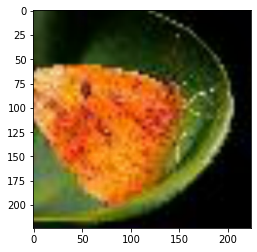

In [20]:
iter = 0
for someimage, somelabel in train_dataset:
    # someimage = someimage.unsqueeze(dim=0)
    #someimage = someimage.to(device)
    iter += 1
    if iter == 5:
    break
    # plt.imshow(someimage.resize(224, 224, 3))
    #plt.show()
    #time.sleep(5)
    # print(someimage.shape)

# print(someimage, somelabel)
print(someimage.shape)
imgshow(someimage)
# someimage

Простой тест на проверку правильности написанного кода

In [21]:
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
random.seed(42)

all_losses, predicted_labels, true_labels = predict(model_v2, val_dataloader, criterion, device)
assert len(predicted_labels) == len(val_dataset)
accuracy = accuracy_score(predicted_labels, true_labels)
print("tests passed")

tests passed


In [22]:
accuracy

0.004

Если ткнуть случайно, вероятность попасть в истинный класс: 1/200=0.005. Близко к полученному. 

Запустить обучение можно в ячейке ниже.

In [23]:
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
random.seed(42)

# train(model, train_dataloader, val_dataloader, criterion, optimizer, device, n_epochs, scheduler)
train(model_v2, train_dataloader, val_dataloader, criterion, optimizer, device, n_epochs, scheduler)

Train Epoch: 0
0 loss: 5.39369535446167 accuracy: 0.0
100 loss: 3.998281240463257 accuracy: 0.21875
200 loss: 3.454244375228882 accuracy: 0.25
300 loss: 2.7035703659057617 accuracy: 0.4375
400 loss: 2.5181405544281006 accuracy: 0.453125
500 loss: 2.5152270793914795 accuracy: 0.4375
600 loss: 2.5826351642608643 accuracy: 0.390625
700 loss: 2.1213247776031494 accuracy: 0.484375
800 loss: 2.0053062438964844 accuracy: 0.5
900 loss: 1.9334588050842285 accuracy: 0.53125
1000 loss: 2.090907096862793 accuracy: 0.5
1100 loss: 1.9588624238967896 accuracy: 0.59375
1200 loss: 2.137545585632324 accuracy: 0.484375
1300 loss: 1.8917620182037354 accuracy: 0.46875
1400 loss: 2.2451765537261963 accuracy: 0.453125
1500 loss: 2.3169734477996826 accuracy: 0.46875
!!! TRAIN EPOCH METRICS: !!!
{'loss': 2.524896995043495, 'accuracy': 0.43931}
Validation Epoch: 0
!!! VAL EPOCH METRICS: !!!
loss: 1.9041285605946923, accuracy: 0.5373
Train Epoch: 1
0 loss: 1.5875895023345947 accuracy: 0.625
100 loss: 1.538115262

После всех экспериментов которые вы проделали, выберите лучшую из своих моделей, запустите функцию evaluate. Эта функция должна брать на вход модель и даталоадер с валидационными данными и возврашать accuracy, посчитанную на этом датасете.

In [24]:
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
random.seed(42)

all_losses, predicted_labels, true_labels = predict(model_v2, val_dataloader, criterion, device)
assert len(predicted_labels) == len(val_dataset)
accuracy = accuracy_score(true_labels, predicted_labels)
print("Оценка за это задание составит {} баллов".format(min(5, 5*accuracy / 0.44)))

Оценка за это задание составит 5 баллов


In [25]:
accuracy

0.5561

__Ваш отчёт о проделанных экспериментах__:

Изначально в аугментации использовал torchvision.transforms.RandomRotation, предобученный resnet18 с измененным последним слоем для задачи и SGD с моментумом (lr=0.001) в качестве оптимизатора (помнится, он один из наиболее универсальных, да и вообще моментум позволяетт круто обновлять веса в зависимости от лосса), но аккураси было в пределах [0.4, 0.48], лосс~2 после 3-5 эпох, а дальше модель начинала переобучаться. Поиграл с learningg rate-ом: 0.001, 0.005, 0.0005, 0.0075, 0.005, метрики примерно в тех же пределах. 

Попробовал поменять оптимизатор  на Adam, результат улучшился, я был удивлен. Объясняю это тем, что обучается, толькоо один слой, а не вся нейросеть, и, в таком случае, SGD с моментум может не успеть "разогнаться", а Adam достаточно прямолинейно сведет веса. Аккурсаси ~ [0.44, 0.48], лосс~1.75. 

Руки дошли до аугментаций. Попробовал убрать RandomRotation, поскольку из всех используемых до этого трансформаций, он казался наименее полезным для создания релеевантной модели классификации: оставлял немаленькие черные куски, и, в целом, казался наименее релевантным для задачи. Помогло. Результат чуть выше. 

## Часть 2. Object detection.

В этом задании потребуется обучить детектор фруктов на изображении. Датасет можно скачать [отсюда](https://yadi.sk/d/UPwQB7OZrB48qQ).

In [26]:
!pip install -U git+https://github.com/albu/albumentations

  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-5xmmmqg0
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-5xmmmqg0
     |████████████████████████████████| 952kB 24.7MB/s 
  Created wheel for albumentations: filename=albumentations-0.5.1-cp36-none-any.whl size=72234 sha256=c0095dbde312da9ead92aa7528925306c4530b39e721df4a0911f9d971cbbf4a
  Stored in directory: /tmp/pip-ephem-wheel-cache-lg3rnqmu/wheels/45/8b/e4/2837bbcf517d00732b8e394f8646f22b8723ac00993230188b
Successfully built albumentations
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [27]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensor

def imgshow(objct):
    to_PIL = torchvision.transforms.ToPILImage()

    img = objct
    img = np.array(to_PIL(img))

    plt.imshow(img)

In [28]:
# еще раз, чтобы не перезапускать код из первого задания
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
! unzip -q -o '/content/drive/My Drive/archive.zip'

In [30]:
# we will need this library to process the labeling
! pip install xmltodict

In [31]:
import pandas as pd
import numpy as np
import random
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
import json
import glob
import cv2
import os
import torchvision
import matplotlib.pyplot as plt
from sklearn.metrics import auc
import xmltodict, json

In [32]:
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
random.seed(42)

class2tag = {"apple": 1, "orange": 2, "banana": 3}


# open dataset and get access to its elements
class FruitDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.images = []
        self.annotations = []
        self.transform = transform
        for annotation in glob.glob(data_dir + "/*xml"):
            image_fname = os.path.splitext(annotation)[0] + ".jpg"
            self.images.append(cv2.cvtColor(cv2.imread(image_fname), cv2.COLOR_BGR2RGB))
            with open(annotation) as f:
                annotation_dict = xmltodict.parse(f.read())
            bboxes = []
            labels = []
            objects = annotation_dict["annotation"]["object"]
            if not isinstance(objects, list):
                objects = [objects]
            for obj in objects:
                bndbox = obj["bndbox"]
                bbox = [bndbox["xmin"], bndbox["ymin"], bndbox["xmax"], bndbox["ymax"]]
                bbox = list(map(int, bbox))
                bboxes.append(torch.tensor(bbox))
                labels.append(class2tag[obj["name"]])
            self.annotations.append(
                {"boxes": torch.stack(bboxes).float(), "labels": torch.tensor(labels)}
            )

    def __getitem__(self, i):
        if self.transform:
            # the following code is correct if you use albumentations
            # if you use torchvision transforms you have to modify it =)
            res = self.transform(
                image=self.images[i],
                bboxes=self.annotations[i]["boxes"],
                labels=self.annotations[i]["labels"],
            )
            
            return res["image"], {
                "boxes": torch.tensor(res["bboxes"]),
                "labels": torch.tensor(res["labels"]),
            }
        else:
            return self.images[i], self.annotations[i]

    def __len__(self):
        return len(self.images)

Выпишем кое-какую техническую работу, которая уже была на семинаре.

In [33]:
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
random.seed(42)

def intersection_over_union(dt_bbox, gt_bbox):
    """
    Intersection over Union between two bboxes
    :param dt_bbox: list or numpy array of size (4,) [x0, y0, x1, y1]
    :param gt_bbox: list or numpy array of size (4,) [x0, y0, x1, y1]
    :return : intersection over union
    """

    intersection_bbox = np.array(
        [
            max(dt_bbox[0], gt_bbox[0]),
            max(dt_bbox[1], gt_bbox[1]),
            min(dt_bbox[2], gt_bbox[2]),
            min(dt_bbox[3], gt_bbox[3]),
        ]
    )

    intersection_area = max(intersection_bbox[2] - intersection_bbox[0], 0) * max(
        intersection_bbox[3] - intersection_bbox[1], 0
    )
    area_dt = (dt_bbox[2] - dt_bbox[0]) * (dt_bbox[3] - dt_bbox[1])
    area_gt = (gt_bbox[2] - gt_bbox[0]) * (gt_bbox[3] - gt_bbox[1])

    union_area = area_dt + area_gt - intersection_area

    iou = intersection_area / union_area
    return iou

def evaluate_sample(target_pred, target_true, iou_threshold=0.5):
    gt_bboxes = target_true["boxes"].numpy()
    gt_labels = target_true["labels"].numpy()

    dt_bboxes = target_pred["boxes"].numpy()
    dt_labels = target_pred["labels"].numpy()
    dt_scores = target_pred["scores"].numpy()

    results = []
    for detection_id in range(len(dt_labels)):
        dt_bbox = dt_bboxes[detection_id, :]
        dt_label = dt_labels[detection_id]
        dt_score = dt_scores[detection_id]

        detection_result_dict = {"score": dt_score}

        max_IoU = 0
        max_gt_id = -1
        for gt_id in range(len(gt_labels)):
            gt_bbox = gt_bboxes[gt_id, :]
            gt_label = gt_labels[gt_id]

            if gt_label != dt_label:
                continue

            if intersection_over_union(dt_bbox, gt_bbox) > max_IoU:
                max_IoU = intersection_over_union(dt_bbox, gt_bbox)
                max_gt_id = gt_id

        if max_gt_id >= 0 and max_IoU >= iou_threshold:
            detection_result_dict["TP"] = 1
            gt_labels = np.delete(gt_labels, max_gt_id, axis=0)
            gt_bboxes = np.delete(gt_bboxes, max_gt_id, axis=0)

        else:
            detection_result_dict["TP"] = 0

        results.append(detection_result_dict)

    return results


def evaluate(model, test_loader, device):
    results = []
    # model = model.to(device)
    model.eval()
    nbr_boxes = 0
    with torch.no_grad():
        for batch, (images, targets_true) in enumerate(test_loader):
            images = list(image.to(device).float() for image in images)
            targets_pred = model(images)
            targets_true = [
                {k: v.cpu().float() for k, v in t.items()} for t in targets_true
            ]
            targets_pred = [
                {k: v.cpu().float() for k, v in t.items()} for t in targets_pred
            ]

            for i in range(len(targets_true)):
                target_true = targets_true[i]
                target_pred = targets_pred[i]
                nbr_boxes += target_true["labels"].shape[0]

                results.extend(evaluate_sample(target_pred, target_true))

    results = sorted(results, key=lambda k: k["score"], reverse=True)

    acc_TP = np.zeros(len(results))
    acc_FP = np.zeros(len(results))
    recall = np.zeros(len(results))
    precision = np.zeros(len(results))

    if results[0]["TP"] == 1:
        acc_TP[0] = 1
    else:
        acc_FP[0] = 1

    for i in range(1, len(results)):
        acc_TP[i] = results[i]["TP"] + acc_TP[i - 1]
        acc_FP[i] = (1 - results[i]["TP"]) + acc_FP[i - 1]

        precision[i] = acc_TP[i] / (acc_TP[i] + acc_FP[i])
        recall[i] = acc_TP[i] / nbr_boxes

    return auc(recall, precision)

Вам мы оставляем творческую часть =)

__Задание__. Обучите модель для object detection на __обучающем__ датасете и добейтесь PR-AUC не менее __0.91__ на  __тестовом__.

 - Создайте модель и оптимайзер
 - Напишите функцию обучения модели
 - Используйте аугментации
 
Использовать аугментации для обучения __обязательно__. Они дадут 1 балл из 5. Пользуйтесь модулем torchvision.transforms или библиотекой albumentations (о которой говорилось ранее). Последняя библиотека особенно удобна, поскольку умеет сама вычислять новые координаты bounding box'ов после трансформаций картинки. Советуем обратить внимание на следующий [гайд](https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/). Обратите внимание, что код, написанный в датасете выше, верен только если вы используете albumentations. Если вы выбрали путь torchvision.transforms, вам потребуется метод `__getitem__` изменить (что-то типа `return self.transform(self.images[i])`; однако в таком случае вычислять новые координаты bounding box'ов после трансформаций вам придётся вручную =))

Оставшиеся 4 балла вычисляются по простой формуле: __min(4, 4 * Ваш auc / 0.91)__.

In [34]:
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
random.seed(42)

# Частивчно позаимствовано из семинаров. Многое пришлось адаптировать и изменять. 
def train_one_epoch(model, train_dataloader, optimizer, device):
    # model = model.to(device)
    model.train()
    n = 0
    global_loss = 0
    for images, targets in train_dataloader:
        images = list(image.to(device).float() for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        dict_loss = model(images, targets)
        losses = sum(loss for loss in dict_loss.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        n += 1
        global_loss += float(losses.cpu().detach().numpy())

        if n % 10 == 0:
            print("Loss value after {} batches is {}".format(n, round(global_loss / n, 2)))

    return global_loss


def train(model, train_dataloader, val_dataloader, optimizer, device, n_epochs=10):
    for epoch in range(n_epochs):
        print('EPOCH: ' + str(epoch))
        model = model.to(device)
        print('STARTING EVALUATION')
        model.eval()
        a = evaluate(model, val_dataloader, device=device)
        print("AUC ON TEST: {:.4f}".format(a))
        model.train()
        train_one_epoch(model, train_dataloader, optimizer, device=device)

### ЗАПУСК

In [35]:
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
random.seed(42)
# Добавил RESIZE, чтобы растягивать и сжимать картинки к единому формату
# Как видите, пробовалл разные аугментации. Остановилсяя на этих. 
# Что-то похожее было в статье https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/
# Но у меня используется еще Resize и другие гиперпараметры

train_transform = A.Compose([
    #A.PadIfNeeded(min_height=350, min_width=350, value=[255,255,255], always_apply=True, p=1.0),
    A.Resize(height=350, width=350, interpolation=1, always_apply=False, p=1),
    # A.Resize(height=350, width=350, always_apply=False, p=1),
    # A.RandomCrop(width=500, height=500),
    # A.CenterCrop(width=350, height=350),
    # A.InvertImg(always_apply=False, p=1),
    # A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
    # A.Rotate(limit=60, interpolation=1, border_mode=4, always_apply=False, p=0.5),
    
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, p=0.2),
    ToTensor()], 
   bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))# CODE FOR AUGMENTATIONS

val_transform = A.Compose([
    # A.PadIfNeeded(min_height=350, min_width=350, border_mode=4, value=[255,255,255], always_apply=False, p=1.0),
    # A.Resize(height=400, width=400, interpolation=1, always_apply=False, p=1),
    # A.Resize(height=350, width=350, interpolation=1, always_apply=False, p=1),
    # A.RandomCrop(width=450, height=450),
    # A.CenterCrop(width=350, height=350),

    A.HorizontalFlip(p=0.1),
    A.RandomBrightnessContrast(p=0.05),
    ToTensor()],
   bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels'])) # CODE FOR VALIDATION AUGMENTATIONS
# HINT: TRAIN TRANSFORM OBVIOUSLY SHOULD BE HARDER THAN THOSE FOR VALIDATION

train_dataset = FruitDataset("/content/archive/train_zip/train", transform=train_transform)
val_dataset = FruitDataset("/content/archive/test_zip/test", transform=val_transform)

In [36]:
train_dataset[3][0].shape

# bnn = torch.tensor(train_dataset[3][0]).reshape((3, 350, 350))
# bnn = torch.tensor(train_dataset[3][0]).permute(2, 0, 1)

# imgshow(bnn)

torch.Size([3, 350, 350])

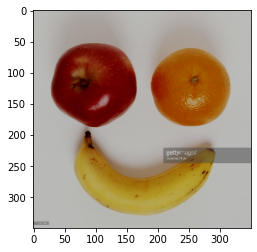

In [37]:
# imgshow(torch.tensor(train_dataset[200][0]))
imgshow(train_dataset[123][0])

Сплющенный банан от Resize лучше, чем просто кусок желтой кожуры на всю картинку от RandomCrop :)

In [38]:
print(train_dataset[239][1])
len(train_dataset), len(val_dataset)

{'boxes': tensor([[119.7778,  21.5000, 345.7222, 224.0000],
        [117.0556,  87.0000, 340.6667, 328.5000]], dtype=torch.float64), 'labels': tensor([3, 3])}


(240, 60)

In [39]:
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
random.seed(42)

# Очень сильная модель. Inspiration from sem07. 
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [40]:
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
random.seed(42)

# sem07 - источник бейзлайна для модели и collate_fn(). 
# Немного поменял формат записи: избавился от функции, вписал изменения прямо в функцию

def collate_fn(batch):
    return tuple(zip(*batch))


model_detect = fasterrcnn_resnet50_fpn(pretrained=True)
# Две закомменченные строчки кода ниже стоили мне пары часов тюнинга модели :)
# Раззобрался, что там фиксируютя некоторые градиенты, которые нужны в модели
# for param in model.parameters():
#   param.requires_grad = False

# get the number of input features for the classifier
in_features = model_detect.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model_detect.roi_heads.box_predictor = FastRCNNPredictor(in_features, 4) # 4 класса в аутпуте

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


In [41]:
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
random.seed(42)

# HINT: USE MATERIALS FROM THE SEMINAR
# YOU CAN USE torchvision.models AND torchvision.models.detection
# READ OFFICIAL DOCS FOR MORE INFO

# Позаимствовано из sem07. 
# Поначалу в качестве параметров для оптимизации передавал только model_detect.roi_heads.box_predictor.parameters(). 
# Но задебажил эту проблему и собрал необходимые для оптимизации параметры так. 
params = [p for p in model_detect.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005) # OPTIMIZER
# optimizer = torch.optim.Adam(params, lr=0.001) 

# sem07 - источник настроек размеров батчей. Пробовал комбинации 2-1, 2-2, 1-1, 1-2, 4-2, 4-4. 
# 2-1 оказалось наиболее оптимальной
train_dataloader = torch.utils.data.DataLoader(train_dataset, 
                              batch_size = 2,
                              shuffle = True,
                              pin_memory=True,
                              collate_fn=collate_fn) # DATALOADER, batch_size
val_dataloader = torch.utils.data.DataLoader(val_dataset, 
                              batch_size = 1,
                              shuffle = True,
                              pin_memory=True,
                              collate_fn=collate_fn)# VALIDATION DATALOADER
n_epochs = 5 # NUMBER OF EPOCHS
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [42]:
# print(model_detect)

In [43]:
# чекал размерности и типы данных

# for batch, (images, targets_true) in enumerate(val_dataloader):
#   # images = torch.tensor(images) #
#   images = [im.to(device) for im in images]
#   print(len(images))
#   print(images[0].shape)
#   print(targets_true[0])
#   # print(targets_true[0])
#   print(len(targets_true))
#   #print(torch.tensor(images)[0].shape)
#   break

In [45]:
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
random.seed(42)

train(model_detect, train_dataloader, val_dataloader, optimizer, device, n_epochs)

EPOCH: 0
STARTING EVALUATION
AUC ON TEST: 0.0027
Loss value after 10 batches is 0.68
Loss value after 20 batches is 0.57
Loss value after 30 batches is 0.52
Loss value after 40 batches is 0.47
Loss value after 50 batches is 0.43
Loss value after 60 batches is 0.41
Loss value after 70 batches is 0.4
Loss value after 80 batches is 0.4
Loss value after 90 batches is 0.38
Loss value after 100 batches is 0.36
Loss value after 110 batches is 0.34
Loss value after 120 batches is 0.34
EPOCH: 1
STARTING EVALUATION
AUC ON TEST: 0.6577
Loss value after 10 batches is 0.26
Loss value after 20 batches is 0.23
Loss value after 30 batches is 0.21
Loss value after 40 batches is 0.21
Loss value after 50 batches is 0.2
Loss value after 60 batches is 0.2
Loss value after 70 batches is 0.21
Loss value after 80 batches is 0.2
Loss value after 90 batches is 0.2
Loss value after 100 batches is 0.19
Loss value after 110 batches is 0.19
Loss value after 120 batches is 0.19
EPOCH: 2
STARTING EVALUATION
AUC ON TE

В пятой эпохе, кажется, модель начала немного переобучаться. Лосс стагнировал(даже немного повышался), accuracy упал немного. 

__Выведите итоговое качество модели__.

In [46]:
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
random.seed(42)

aucc = evaluate(model_detect, val_dataloader, device)
print("Оценка за это задание составит {} баллов".format(min(4, 4 * aucc / 0.91)))

Оценка за это задание составит 4 баллов


In [47]:
aucc

0.9246694844260921

Нарисуйте предсказанные bounding box'ы для любых двух картинок из __тестового__ датасета.

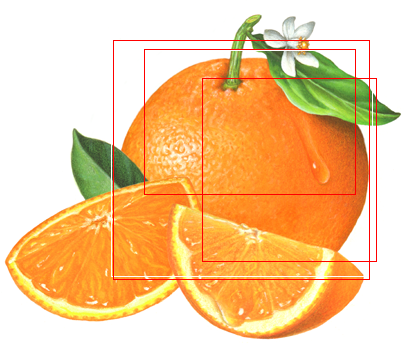

In [48]:
image, labels = val_dataset[1]

# image, labels = next(iter(train_dataset))
pred = model_detect(image.unsqueeze(0).to(device))[0]

from PIL import ImageDraw

image = torchvision.transforms.ToPILImage()(image)
draw = ImageDraw.Draw(image)
for box in labels['boxes']:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])])
    
for box in pred['boxes']:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline='red')
image

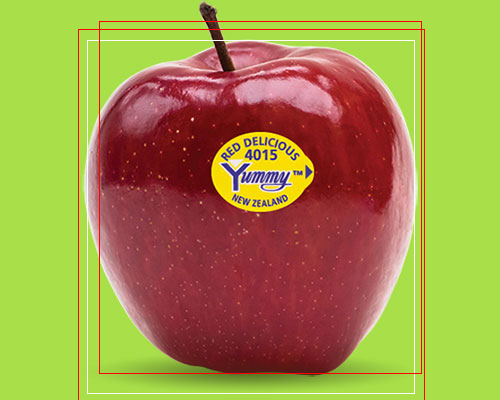

In [49]:
image, labels = val_dataset[9]

# image, labels = next(iter(train_dataset))
pred = model_detect(image.unsqueeze(0).to(device))[0]

from PIL import ImageDraw

image = torchvision.transforms.ToPILImage()(image)
draw = ImageDraw.Draw(image)
for box in labels['boxes']:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])])
    
for box in pred['boxes']:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline='red')
image

Удивительно, что при auc ~ 0.84, что, кажется, очень высоко тоже, bounding box'ы наслаивались по 2-4 штуки на каждое яблоко. Так непривычно видеть этии аккуратные боксы, обрамляющие яблоки на изображениях. Правда, на картинках с большим количеством фруктов, модель, по-прежнему, немного теряется и накидывает по несколько слоев друг на друга. 

__Вкратце о проделанных экспериментах__:

Сначала пробовалл много аугментаций на трейне и валидации: паддинг, Random/Center-Crop, Resize, отзеркаливание, затемнение, яркость. Потом, наоборот, отказался от большого количества аугментаций(крутость в минимализме): в трейне только ресайзил, зеркалил и изменял яркость, в валидациии то же самое, но без ресайза и с меньшими вероятностями. 

Пробовал менять оптимизаторы: Adam (с разными шагами(lr in [0.001, 0.0005, 0.0001])) и SGD с моментумом. Первый сходился медленнее и менее точно, либо, наоборот, быстрее, но сразу переобучался(при большом лернинг рейте). 

Нашел баг, описанный в создании модели, с фиксированием некоторых важныых градиентов, и передачей в оптимизатор не всех необходимых параметров. 

Эксперименты с размерами батчей в трейне и валидации описаны выше. Количество эпох определялось исключительно экспериментальо и изменялось в зависимости от набора гиперпараметров и модели в пределах [3, 10]. 

## Бонус (10 баллов).

__Задание__. В части с классификацией добейтесь accuracy не менее 0.52. Напишите отчёт о проделанных экспериментах.

__Критерии оценки__. Оценка за бонусную часть равна 10, если вы преодолели качество 0.52 и 0 в противном случае.

__Иных оценок кроме 0 и 10 не предусмотрено__.

Изменением условия, конечно, не очень порадовали. 

> 0.52 пробит. 

Теперь решм задачу для более высокого уровня accuracy. 

## Бонус (0 баллов).

__Задание 1__. Скиньте ниже смешную картинку, желательно про машинное обучение. На картинке не должно быть никаких упоминаний лектора, семинаристов и ассистентов этого курса.

__Задание 2__. Расскажите, как вам задание? Что понравилось, что не понравилось, что можно улучшить? Мы примем во внимание любой фидбек.

Задание отличное. Очень время- и энергозатратное, но очень интересное. И это прекрасно. Спасибо за это огромноое!

Что было бы классно поменять: не менять условие в течение последней недели :)

Сначала в первом задании что-то пошло не так и я сделал это. 

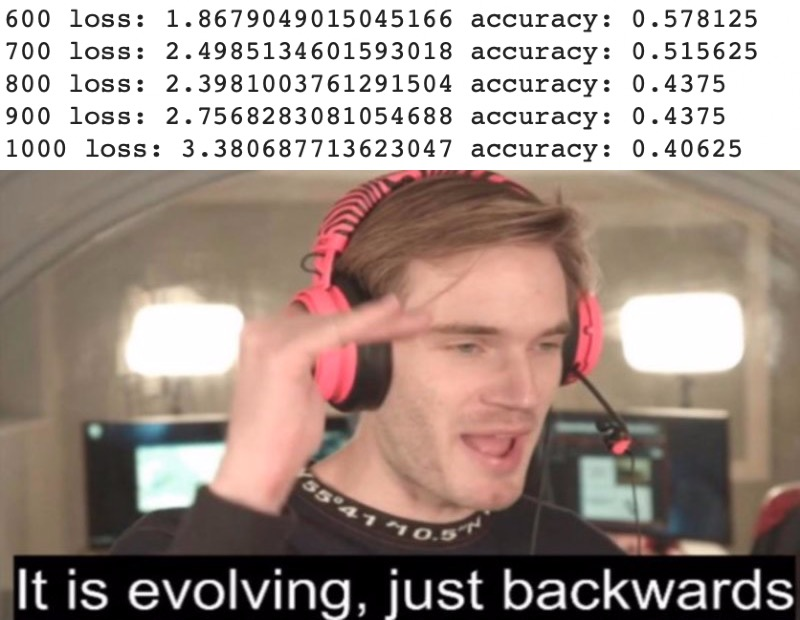

_Основано на реальных событиях_

Но через день аналогичный мем появился в паблике с шутками про глубинное обучение. 

Не могу оставить это так. Так что ловите еще один. 

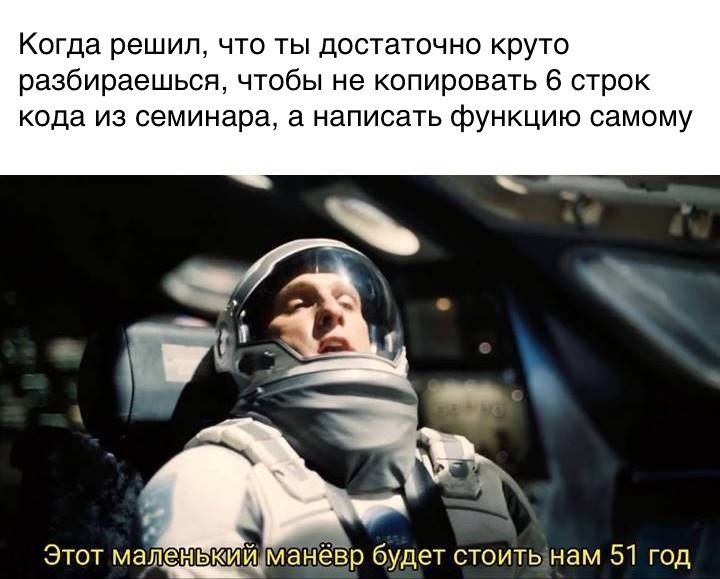

All rights reserved. Мемы делал сам. Жду их в беседе. 

Добра вам! 

Давид